In [1]:
import numpy as np
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

# Import

First we open a file containing a dictionary of columns and associated data types generated in `../../optimize/`, then we read input file.

In [5]:
with open('../input/dtypes.yaml', 'r') as yamlfile:
    column_types = yaml.load(yamlfile)

read_csv_opts = {'sep': '|',
                 'quotechar': '"',
                 'compression': 'gzip',
                 'encoding': 'utf-8',
                 'dtype': column_types,
                 'parse_dates': ['MissionDate'],
                 'infer_datetime_format': True}

df = pd.read_csv('../input/ice-air.csv.gz', **read_csv_opts)

df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1763020 entries, 0 to 1763019
Data columns (total 43 columns):
Status                  category
Sex                     category
Convictions             category
GangMember              category
ClassLvl                float32
Age                     float32
MissionDate             datetime64[ns]
MissionNumber           uint32
PULOC                   category
DropLoc                 category
StrikeFromList          float32
ReasonStruck            category
R-T                     category
Code                    category
CountryOfCitizenship    category
Juvenile                object
MissionWeek             uint8
MissionQuarter          uint8
MissionYear             uint16
MissionMonth            uint8
Criminality             category
FamilyUnitFlag          float32
UnaccompaniedFlag       float32
AlienMasterID           uint32
MissionID               uint16
air_AirportID           float32
air_AirportName         category
air_City       

# Juveniles

- [ ] Has the number of minors being repatriated increased over time? For what countries? 
- [ ] How many minors are typically on a flight? 
- [ ] Are there flights with only minors?
- [ ] Increase in deportations of minors to Guatemala?
  - [ ] Instances of more than 20 unaccompanied minors in Guatemala in one day

In [7]:
nationality = 'GUATEMALA'

nationality_df = df[df['CountryOfCitizenship'] == str(nationality).upper()]

In [8]:
groupby = nationality_df.groupby(['CountryOfCitizenship','MissionDate', 'R-T', 'PULOC', 'DropLoc'])

In [10]:
table = groupby['AlienMasterID'].nunique().reset_index(name='AlienMasterIDCount')
table['MissionIDCount'] = groupby['MissionID'].nunique().reset_index(name='MissionIDCount')['MissionIDCount']

repatriations = table[table['R-T'] == 'R'].copy()
transfers = table[table['R-T'] == 'T'].copy()

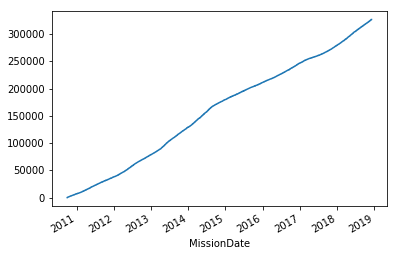

In [11]:
repatriations.set_index('MissionDate', inplace=True)

r_cum = repatriations['AlienMasterIDCount'].cumsum()
t_cum = transfers['AlienMasterIDCount'].cumsum()

r_cum.plot();

In [12]:
juv_table = groupby['Juvenile'].sum().reset_index(name='Juveniles')

In [13]:
juv_repatriations = juv_table[juv_table['R-T'] == 'R'].copy()
juv_transfers = juv_table[juv_table['R-T'] == 'T'].copy()

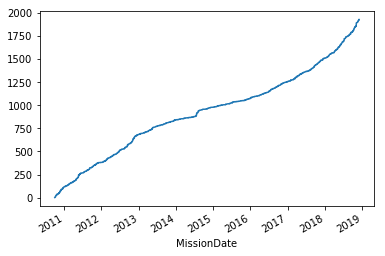

In [14]:
juv_repatriations.set_index('MissionDate', inplace=True)

juv_r_cum = juv_repatriations['Juveniles'].cumsum()

juv_r_cum.plot()

In [15]:
juv_repatriations.head()

,CountryOfCitizenship,R-T,PULOC,DropLoc,Juveniles
MissionDate,,,,,
2010-10-01,GUATEMALA,R,KHRL,MGGT,0
2010-10-01,GUATEMALA,R,KIWA,MGGT,0
2010-10-01,GUATEMALA,R,KSAT,MGGT,0
2010-10-04,GUATEMALA,R,KMIA,MGGT,4
2010-10-05,GUATEMALA,R,KELP,MGGT,0


In [16]:
repatriations['Juveniles'] = juv_repatriations['Juveniles']
repatriations['Juveniles'].value_counts()


0     3073
1      527
2      195
3      101
4       58
5       24
7       14
6        7
9        6
8        3
13       2
14       2
16       1
10       1
11       1
12       1
15       1
25       1
Name: Juveniles, dtype: int64

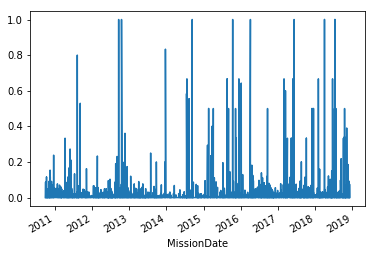

In [17]:
repatriations['JuvPercent'] = juv_repatriations['Juveniles'] / repatriations['AlienMasterIDCount']

repatriations.tail(20)

repatriations['JuvPercent'].plot();

In [18]:
repatriations

,CountryOfCitizenship,R-T,PULOC,DropLoc,AlienMasterIDCount,MissionIDCount,Juveniles,JuvPercent
MissionDate,,,,,,,,
2010-10-01,GUATEMALA,R,KHRL,MGGT,67,1,0,0
2010-10-01,GUATEMALA,R,KIWA,MGGT,121,1,0,0
2010-10-01,GUATEMALA,R,KSAT,MGGT,37,1,0,0
2010-10-04,GUATEMALA,R,KMIA,MGGT,46,1,4,0.0869565
2010-10-05,GUATEMALA,R,KELP,MGGT,23,1,0,0
2010-10-05,GUATEMALA,R,KIWA,MGGT,112,1,0,0
2010-10-06,GUATEMALA,R,KDAL,MGGT,14,1,0,0
2010-10-06,GUATEMALA,R,KIAH,MGGT,29,1,0,0
2010-10-07,GUATEMALA,R,KAEX,MGGT,127,1,0,0


# All juveniles

In [28]:
juv_df = df[df['Juvenile'] == True]

In [37]:
df['Juvenile'].value_counts()

False    1735639
True       26197
Name: Juvenile, dtype: int64

In [35]:
sum(df['Juvenile'])

nan

In [29]:
groupby_juv = juv_df.groupby(['CountryOfCitizenship','MissionDate', 'R-T', 'PULOC', 'DropLoc'])

In [30]:
table = groupby_juv['AlienMasterID'].nunique().reset_index(name='AlienMasterIDCount')
table['MissionIDCount'] = groupby_juv['MissionID'].nunique().reset_index(name='MissionIDCount')['MissionIDCount']
table['JuvenileCount'] = groupby_juv['Juvenile'].sum().reset_index(name='JuvenileCount')['JuvenileCount']

repatriations = table[table['R-T'] == 'R'].copy()
transfers = table[table['R-T'] == 'T'].copy()

In [31]:
repatriations.set_index('MissionDate', inplace=True)
transfers.set_index('MissionDate', inplace=True)

In [32]:
repatriations = repatriations.sort_index()
transfers = transfers.sort_index()

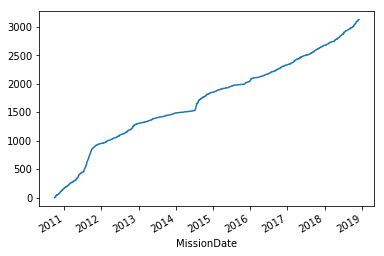

In [33]:
r_cum = repatriations['AlienMasterIDCount'].cumsum()
t_cum = transfers['AlienMasterIDCount'].cumsum()

r_cum.plot();

In [34]:
table

,CountryOfCitizenship,MissionDate,R-T,PULOC,DropLoc,AlienMasterIDCount,MissionIDCount,JuvenileCount
0,ARMENIA,2016-04-23,T,KSAN,KSAT,1,1,True
1,ARMENIA,2016-04-27,T,KSAN,KSAT,2,1,2
2,ARMENIA,2016-05-04,T,KSAN,KSAT,2,1,2
3,BANGLADESH,2013-12-24,T,KBRO,KGYY,1,1,True
4,BANGLADESH,2014-02-11,T,KBRO,KGYY,1,1,True
5,BANGLADESH,2014-07-29,T,KBRO,KGYY,1,1,True
6,BOLIVIA,2011-06-01,T,KMDT,KAEX,1,1,True
7,BRAZIL,2014-05-25,T,KBRO,KTUS,2,1,2
8,BRAZIL,2014-05-30,T,KLRD,KTUS,1,1,True
9,BRAZIL,2014-09-12,T,KBRO,KGYY,1,1,True
